# Canny Edge Detection


In [39]:
import numpy as np
import cv2
from sklearn import mixture
import scipy.stats as stats
from matplotlib import pyplot as plt

In [3]:
import os
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
data_path = "/content/drive/My Drive/Colab Notebooks/DIP/Data"

Mounted at /content/drive


In [4]:
def show_image(image, title):
    if(len(image.shape)==2):
        plt.imshow(image, cmap = 'gray', interpolation = 'bicubic', vmin=0, vmax=255)
    else:
        plt.imshow(image, interpolation = 'bicubic', vmin=0, vmax=255)
    
    plt.title(title)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [5]:
def get_gradient_mag_phase(image):
    # Soblel kernels
    Sx = np.asarray([[-1, 0, 1 ],[-2, 0, 2],[-1, 0, 1]], dtype=np.float)
    Sy = np.asarray([[1, 2, 1 ],[0, 0, 0,],[-1, -2, -1]], dtype=np.float)
    
    Gx = cv2.filter2D(image,cv2.CV_32F,Sx)
    Gy = cv2.filter2D(image,cv2.CV_32F,Sy) 
    # Magnitude
    G=np.sqrt(np.square(Gx)+np.square(Gy))
    # Phase
    Theta = np.degrees(np.arctan2(Gy,Gx)).astype(np.int)
    Theta = np.where(Theta < 0, Theta, Theta+180)
    ## Here I usse lambda functions but you can do in many other ways
    Theta = np.vectorize(lambda x: ((int((x+22.5)/45.))*45)%180)(Theta)
    
    return G, Theta

In [6]:
def non_maxima_suppression(G, Theta):
    
    edge_candidates=np.zeros(G.shape, dtype=np.uint8)
    
    for i in range(1,G.shape[0]-1): 
        for j in range(1,G.shape[1]-1):
            if Theta[i,j] == 0:
                if np.max([G[i,j-1],G[i,j],G[i,j+1]]) == G[i,j]:
                    edge_candidates[i,j] = 1
            elif Theta[i,j] == 45:
                if np.max([G[i+1,j-1],G[i,j],G[i-1,j+1]]) == G[i,j]:
                    edge_candidates[i,j] = 1
            elif Theta[i,j] == 90:
                if np.max([G[i-1,j],G[i,j],G[i+1,j]]) == G[i,j]:
                    edge_candidates[i,j] = 1
            elif Theta[i,j] == 135:
                if np.max([G[i-1,j-1],G[i,j],G[i+1,j+1]]) == G[i,j]:
                    edge_candidates[i,j] = 1
        
    return edge_candidates

In [50]:
def thresholds_estimation(G):
  gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
  gmm.fit(G.reshape(-1,1))
  weights = gmm.weights_
  means = gmm.means_
  covars = gmm.covariances_

  plt.hist(np.log(1.0+G.reshape(-1,1)), bins=100, histtype='bar', density=True, ec='red', alpha=0.5)
  #plt.plot(G.reshape(-1,1),weights[0]*stats.norm.pdf(G.reshape(-1,1),means[0],np.sqrt(covars[0])), c='red')
  #plt.rcParams['agg.path.chunksize'] = 10000

  plt.grid()
  plt.show()

 

In [10]:
def hysteresis_thresholding(G, edge_candidates, th_low, th_high):
    
    thresholds_estimation(G)
    # Set all pixel with G > th_high as edges
    edges=np.where(G > th_high, 1, 0)
    # Discard non local maxima
    edges=np.multiply(edges, edge_candidates)
    #Check weak edges 3x3
    for i in range(1,G.shape[0]-1): 
        for j in range(1,G.shape[1]-1):
            if G[i,j]>th_low and edges[i,j]!=1 and edge_candidates[i,j]==1:
                # Look for strong edges in 3x3
                if np.max(edges[i-1:i+1,j-1:j+1])>0:
                    edges[i,j]=1
   
    #Check weak edges 5x5, you can iterate more. It is equivalent to propagate strong edges torwards weak edges
    for i in range(1,G.shape[0]-1): 
        for j in range(1,G.shape[1]-1):
            if G[i,j]>th_low and edges[i,j]!=1 and edge_candidates[i,j]==1:
                # Look for strong edges in 3x3
                if np.max(edges[i-1:i+1,j-1:j+1])>0:
                    edges[i,j]=1
    edges=edges.astype(dtype=np.uint8)
    return edges

In [12]:
# Canny Edge
def canny_edge(image,th_low,th_high):
    #1 Gaussian low pass - remove noise 
    gauss_image=cv2.GaussianBlur(image,(5,5),0) 
    #2 Gradient estimation
    G, Theta = get_gradient_mag_phase(gauss_image)
    #3 Non maxima suppresion
    edge_candidates=non_maxima_suppression(G, Theta)
    #4 Hysteresis thresholding
    edge_map = hysteresis_thresholding(G, edge_candidates, th_low, th_high)
    return edge_map

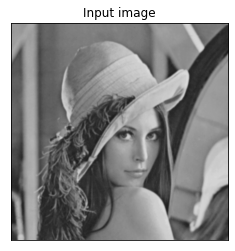

In [13]:
# Load and Display the Image
image = None
image = cv2.imread(data_path+"/lena.png")#, cv2.IMREAD_GRAYSCALE) 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
if image is  None:
    print("Unable to load the Image, check file name")
    
show_image(gray, "Input image")

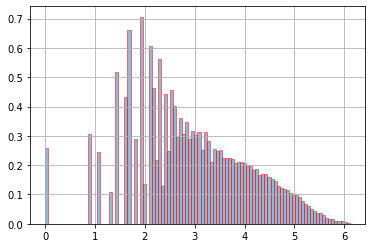

In [51]:
edge_map_gray= canny_edge(gray,20,110)

model Parameters [0.6600421 0.3399579]
model Parameters [[11.77876599]
 [80.37537351]]
model Parameters [[[  67.21229655]]

 [[3831.09872578]]]


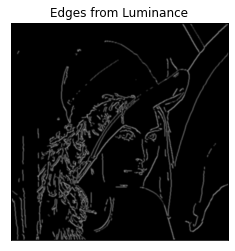

In [36]:
edge_map_gray= canny_edge(gray,20,100)
#edge_map_b=canny_edge(image[:,:,0],5,60)
#edge_map_g=canny_edge(image[:,:,1],5,60)
#edge_map_r=canny_edge(image[:,:,2],5,60)

#edge_map_color=np.maximum(edge_map_b,edge_map_g,edge_map_r)

show_image(255*edge_map_gray, "Edges from Luminance")

#show_image(255*edge_map_color, "Edges from colors")

#show_image(255*edge_map_b, "Edges from b")

#show_image(255*edge_map_g, "Edges from g")

#show_image(255*edge_map_r, "Edges from r")

